# Melbourne Housing Prices

In this analysis, we will evaluate the main price drivers within the Melbourne housing market.  The data set comes from [Kaggle](https://www.kaggle.com/anthonypino/melbourne-housing-market#MELBOURNE_HOUSE_PRICES_LESS.csv).  There are two tables of data included.  The first was scraped in January 2016 and contains about 35,000 records with 21 features.  The second was scraped in May of 2018 and contains 63,000 records with only 13 features.

We will have two goals:
1. Try to make the most accurate model for the 2016 data.
2. Modify that model to be used on the more limited 2018 data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',30)

### Metadata

- Suburb: Suburb
- Address: Address
- Rooms: Number of rooms
- Price: Price in Australian dollars
- Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
- Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
- SellerG: Real Estate Agent
- Date: Date sold
- Distance: Distance from CBD in Kilometres
- Regionname: General Region (West, North West, North, North east ...etc)
- Propertycount: Number of properties that exist in the suburb.
- Bedroom2 : Scraped # of Bedrooms (from different source)
- Bathroom: Number of Bathrooms
- Car: Number of carspots
- Landsize: Land Size in Metres
- BuildingArea: Building Size in Metres
- YearBuilt: Year the house was built
- CouncilArea: Governing council for the area
- Lattitude: Self explanitory
- Longtitude: Self explanitory

In [2]:
df = pd.read_csv('./melbourne-housing-market/Melbourne_housing_FULL.csv')

In [3]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
suburb_count = df['Suburb'].value_counts().sort_values(ascending=False).reset_index(drop=False)

In [5]:
suburb_count.head()

,index,Suburb
0,Reservoir,844
1,Bentleigh East,583
2,Richmond,552
3,Glen Iris,491
4,Preston,485


In [6]:
df.shape

(34857, 21)

In [7]:
columns = df.columns

for col in columns:
    na_count = df[col].isna().sum()
    print(col, ':\t', na_count)

Suburb :	 0
Address :	 0
Rooms :	 0
Type :	 0
Price :	 7610
Method :	 0
SellerG :	 0
Date :	 0
Distance :	 1
Postcode :	 1
Bedroom2 :	 8217
Bathroom :	 8226
Car :	 8728
Landsize :	 11810
BuildingArea :	 21115
YearBuilt :	 19306
CouncilArea :	 3
Lattitude :	 7976
Longtitude :	 7976
Regionname :	 3
Propertycount :	 3


In [8]:
df = df.dropna()

In [9]:
df.shape

(8887, 21)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year-Month'] = df['Date'].dt.to_period('M')
df['Year'] = df['Date'].dt.to_period('Y')
earliest_listing = df['Date'].min()
df['TimeDelta'] = (df['Date'] - earliest_listing).dt.days

In [11]:
def dummy(df, col):
    for c in col:
        df = pd.concat([df, pd.get_dummies(df[c], prefix=c)], axis=1)
        df = df.drop(columns=c, axis=1)
    return df

categorical_colums = ['Suburb', 'Year-Month', 'Year', 'Type', 'Method', 'CouncilArea', 'Regionname']

df = dummy(df, categorical_colums)

In [12]:
df.head()

,Address,Rooms,Price,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,...,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
2,25 Bloomburg St,2,1035000.0,Biggin,2016-04-02,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,5 Charles St,3,1465000.0,Biggin,2017-04-03,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6,55a Park St,4,1600000.0,Nelson,2016-04-06,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
11,124 Yarra St,3,1876000.0,Nelson,2016-07-05,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
14,98 Charles St,2,1636000.0,Nelson,2016-08-10,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


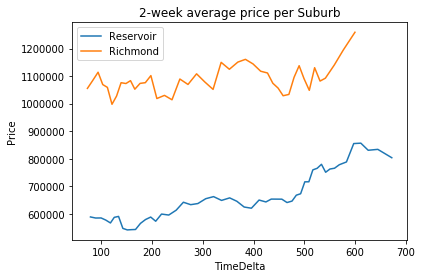

In [13]:
reservoir = df.query('Suburb_Reservoir == 1')
res_avgprice = reservoir.groupby(['TimeDelta'])['Price'].mean().reset_index(drop=False).sort_values('TimeDelta')
res_14d_avgprice = res_avgprice.rolling(window=14).mean()

richmond = df.query('Suburb_Richmond == 1')
rich_avgprice = richmond.groupby(['TimeDelta'])['Price'].mean().reset_index(drop=False).sort_values('TimeDelta')
rich_14d_avgprice = rich_avgprice.rolling(window=14).mean()

sns.lineplot(data=res_14d_avgprice, x='TimeDelta', y='Price')
sns.lineplot(data=rich_14d_avgprice, x='TimeDelta', y='Price')
plt.title('2-week average price per Suburb')
plt.legend(['Reservoir', 'Richmond'])
plt.show()

In [14]:
Y = df['Price']
X = df.loc[:, ~(df.columns.isin(['Price', 'Address', 'SellerG', 'Date', 'Lattitude', 'Longtitude']))]

In [15]:
from sklearn.preprocessing import scale
X_scale = scale(X)

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y, random_state=150)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linr = LinearRegression().fit(X_train, Y_train)
linr_pred = linr.predict(X_test)
r2_score(Y_test, linr_pred)

-2.5744870409597417e+26

In [18]:
from sklearn.linear_model import Ridge

lambda_range = [0.001, 0.01, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.9, 1]

for c in lambda_range:
    ridge = Ridge(alpha=c).fit(X_train, Y_train)
    ridge_pred = ridge.predict(X_test)
    print(c, ':\t', r2_score(Y_test, ridge_pred))

0.001 :	 0.7299522130764182
0.01 :	 0.729952518540887
0.1 :	 0.7299555225885382
0.25 :	 0.7299603401282713
0.35 :	 0.7299634334508257
0.5 :	 0.7299679156598717
0.65 :	 0.7299722287145992
0.75 :	 0.7299750198288892
0.9 :	 0.7299790926451429
1 :	 0.729981738348995


In [19]:
from sklearn.linear_model import Lasso

for c in lambda_range:
    lasso = Lasso(alpha=c, max_iter=2000).fit(X_train, Y_train)
    lasso_pred = lasso.predict(X_test)
    print(c, ':\t', r2_score(Y_test, lasso_pred))

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001 :	 0.7269689120765613


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.01 :	 0.7269774843571069


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.1 :	 0.7270596593806713


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.25 :	 0.7271810055287232


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.35 :	 0.7272600152134026


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.5 :	 0.7273786839144747


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.65 :	 0.7274942299026983


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.75 :	 0.7275698673196411


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9 :	 0.7276813039949561
1 :	 0.7277544376916645


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, Y_train)
rfr_pred = rfr.predict(X_test)

print(r2_score(Y_test, rfr_pred))

0.8304514302796627


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X_train, Y_train)
gbr_pred = gbr.predict(X_test)

print('R2 test: ', r2_score(Y_test, gbr_pred))

R2 test:  0.8321921620731745


In [22]:
feat_importance = pd.DataFrame({
    'Features': X.columns,
    'Importance': rfr.feature_importances_
})


In [23]:
feat_importance.sort_values('Importance', ascending=False)

,Features,Importance
7,BuildingArea,3.476702e-01
402,Regionname_Southern Metropolitan,1.618360e-01
8,YearBuilt,1.173260e-01
1,Distance,9.258248e-02
6,Landsize,6.943346e-02
397,Regionname_Eastern Metropolitan,1.885201e-02
2,Postcode,1.843739e-02
0,Rooms,1.690371e-02
4,Bathroom,1.647909e-02
10,TimeDelta,1.472229e-02


In [24]:
X_sm = X.loc[:, ['Rooms', 
                   'Bedroom2', 
                   'Bathroom', 
                   'Car', 
                   'Landsize', 
                   'BuildingArea', 
                   'Propertycount', 
                   'Distance', 
                   'Type_h',
                   'Type_u',
                   'Type_t']]

X_sm_train, X_sm_test, Y_sm_train, Y_sm_test = train_test_split(X_sm, Y, random_state=150)

linr2 = LinearRegression().fit(X_sm_train, Y_sm_train)
linr2_pred = linr2.predict(X_sm_test)

r2_score(Y_sm_test, linr2_pred)


0.4893760102527376

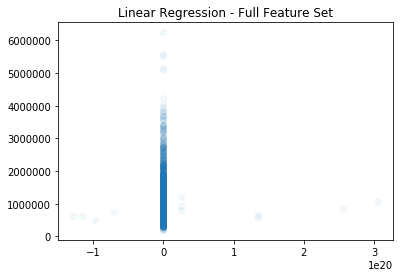

In [25]:
plt.scatter(linr_pred, Y_test, alpha=.05)
plt.title('Linear Regression - Full Feature Set')
plt.show()

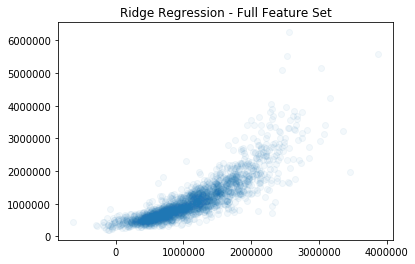

In [26]:
plt.scatter(ridge_pred, Y_test, alpha=0.05)
plt.title('Ridge Regression - Full Feature Set')
plt.show()

In [27]:
ridge_df = pd.DataFrame({
    'Feature': X.columns,
    'Coeficient': ridge.coef_,
}).sort_values('Coeficient', ascending=False)

ridge_df

,Feature,Coeficient
0,Rooms,147729.988042
7,BuildingArea,115461.037124
4,Bathroom,111392.744333
356,Type_h,82882.962482
402,Regionname_Southern Metropolitan,76391.125892
10,TimeDelta,61444.226807
366,CouncilArea_Boroondara City Council,61394.697733
53,Suburb_Brighton,53499.498788
5,Car,51968.876617
209,Suburb_Middle Park,50641.664160


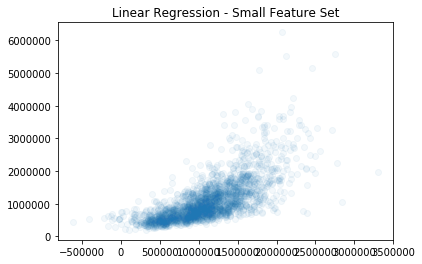

In [28]:
plt.scatter(linr2_pred, Y_test, alpha=.05)
plt.title('Linear Regression - Small Feature Set')
plt.show()

In [29]:
for c in lambda_range:
    ridge_sm = Ridge(alpha=c).fit(X_sm_train, Y_sm_train)
    ridge_sm_pred = ridge_sm.predict(X_sm_test)
    print(c, ':\t', r2_score(Y_sm_test, ridge_sm_pred))

0.001 :	 0.4893760268443239
0.01 :	 0.4893761761600224
0.1 :	 0.48937766846826025
0.25 :	 0.4893801522242721
0.35 :	 0.48938180568819845
0.5 :	 0.4893842823321112
0.65 :	 0.4893867547233923
0.75 :	 0.48938840062706757
0.9 :	 0.48939086595487635
1 :	 0.489392507159635


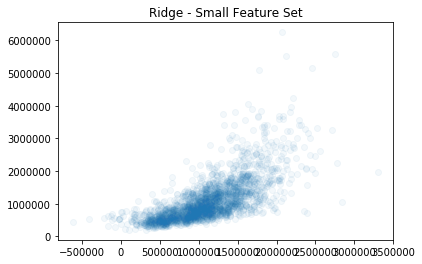

In [30]:
plt.scatter(ridge_sm_pred, Y_sm_test, alpha=.05)
plt.title('Ridge - Small Feature Set')
plt.show()

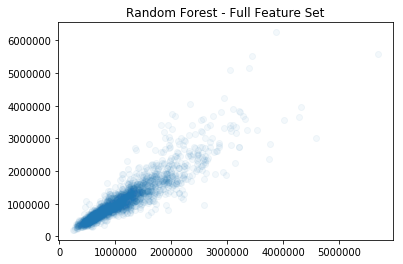

In [31]:
plt.scatter(rfr_pred, Y_test, alpha=.05)
plt.title('Random Forest - Full Feature Set')
plt.show()

0.7587457624794701


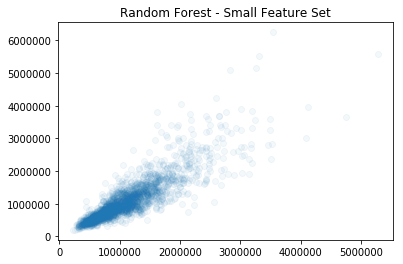

In [32]:
rfr_sm = RandomForestRegressor(n_estimators=100)
rfr_sm.fit(X_sm_train, Y_sm_train)
rfr_sm_pred = rfr_sm.predict(X_sm_test)

print(r2_score(Y_sm_test, rfr_sm_pred))

plt.scatter(rfr_sm_pred, Y_sm_test, alpha=0.05)
plt.title('Random Forest - Small Feature Set')
plt.show()

# EDA

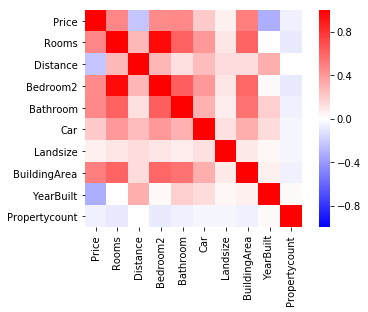

In [33]:
df_eda = df[['Price', 
             'Rooms', 
             'Distance', 
             'Bedroom2', 
             'Bathroom', 
             'Car', 
             'Landsize', 
             'BuildingArea', 
             'YearBuilt', 
             'Propertycount']]

sns.heatmap(df_eda.corr(), vmax=1, vmin=-1, cmap='bwr', square=True)